In [18]:
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}
FSIZE = [5,4]
FDPI = 100
SAVEFIGS = True

In [2]:
def effective_XP_exp(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*np.power(1 + (0.05/0.6), (row['AC'] + row['AB'] - 16))

def effective_XP_linear(row):
    return 0.25*row['HP Mean']*row['DPR Mean']*(1 + (0.05/0.6)*(row['AC'] + row['AB'] - 16))

In [3]:
dfD0 = pd.read_csv('dmg-targets.csv') # 'CR','XP','HP Mean','AC','DPR Mean','AB'
dfD0['eXP exp'] = dfD0.apply(lambda row: effective_XP_exp(row), axis=1)
dfD0['eXP linear'] = dfD0.apply(lambda row: effective_XP_linear(row), axis=1)

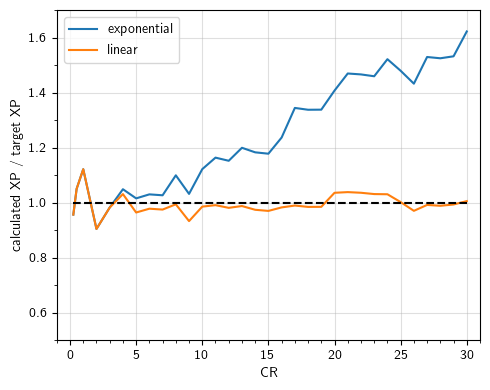

In [45]:
# Shows how the calculated XP for typical monsters of each CR compare with listed XP values
dfD = dfD0[dfD0['CR'].gt(1/8)]

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

columns = ['eXP exp','eXP linear']
labels = ['exponential', 'linear']

for column, label in zip(columns, labels):
    ax.plot(dfD['CR'], dfD[column]/dfD['XP'], '-', label=label)

ax.plot(dfD['CR'], [1.0]*len(dfD['CR']), '--', color='k')

ax.set(xlim=[-1,31], ylim=[0.5,1.7], xlabel='CR', ylabel='calculated XP / target XP')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.grid(which='major', axis='both', alpha=0.4)

ax.label_outer()
ax.legend()

if SAVEFIGS: plt.savefig('./fig-effective-xp-ratio-vs-cr.svg', metadata=METADATA)

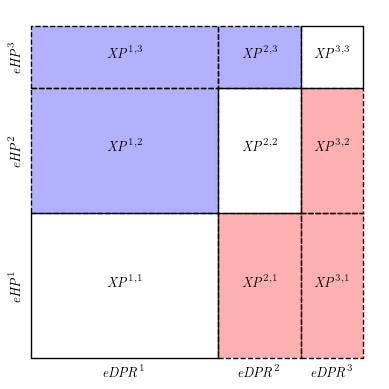

In [49]:
# An example encounter diagram to illustrate what the encounter multiplier represents.
plt.rcParams['text.usetex'] = True

x_mins  = [0, 9, 13]
y_mins  = [0, 7, 13]
widths  = [9, 4,  3]
heights = [7, 6,  3]
color_diag = 'w'
color_bot = 'r'
color_top = 'b'

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

for i in range(3):
    for j in range(3):
        if i < j:
            fc = color_top
            ls = '--'
        elif i > j:
            fc = color_bot
            ls = '--'
        else:
            fc = 'white'
            ls = '-'

        rectangle = plt.Rectangle((x_mins[i],y_mins[j]), widths[i], heights[j], fc=fc, ec='none', alpha=0.3)
        ax.add_patch(rectangle)

        rectangle = plt.Rectangle((x_mins[i],y_mins[j]), widths[i], heights[j], fc='none', ec='black', linestyle=ls)
        ax.add_patch(rectangle)

        ax.text(x_mins[i] + 0.5*widths[i], y_mins[j] + 0.5*heights[j], 
            r'$\mathit{{XP}}^{{{:},{:}}}$'.format(i+1,j+1), fontsize=10, ha='center')

for i in range(3):
    ax.text(x_mins[i] + 0.5*widths[i], -0.7, r'$\mathit{{eDPR}}^{{{:}}}$'.format(i+1), fontsize=10, ha='center', va='center')

for j in range(3):
    ax.text(-0.7, (y_mins[j] + 0.5*heights[j]), r'$\mathit{{eHP}}^{{{:}}}$'.format(j+1), fontsize=10, ha='center', va='center', rotation='vertical')

#ax.text(8.0, -0.7, r'$\mathit{eDPR}$', fontsize=12, ha='center', va='center')
#ax.text(-0.7, 8.0, r'$\mathit{eHP}$', fontsize=12, ha='center', va='center', rotation='vertical')
plt.axis('off')
plt.axis('scaled')

if SAVEFIGS: plt.savefig('./fig-xp-encounter-diagram.svg', metadata=METADATA)

plt.rcParams['text.usetex'] = False
